## Stratifying Players Using KMeans

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# pull data from csv, keep columns that have to do w/ fantasy points, make a games column for aggregating
data = pd.read_csv('test_data/2021_fantasy_scores.csv')
data = data[['player_id','player_name','min','fg3m','fgm','ftm','dreb','oreb','ast','blk','stl','tov','fantasy_score','fantasy_score_cumul']]
data['games'] = 1

In [3]:
# aggregate fields goruping by player
f_scores = data.groupby(['player_id','player_name']).agg({
    'min':  ['sum'],
    'fg3m': ['sum'],
    'fgm':  ['sum'],
    'ftm':  ['sum'],
    'dreb': ['sum'],
    'oreb': ['sum'],
    'ast':  ['sum'],
    'blk':  ['sum'],
    'stl':  ['sum'],
    'tov':  ['sum'],
    'fantasy_score_cumul':['max'],
    'fantasy_score':['mean'],
    'games':['sum']
})
# reset column names and index
f_scores.columns = ['min','fg3m','fgm','ftm','dreb','oreb','ast','blk','stl','tov','season_points','avg_points','games_played']
f_scores = f_scores.reset_index()

In [4]:
pd.set_option('display.max_rows', None) # use this show all rows in dataframe

# season_points = cumulative fantasy points
# avg_points = avg fantasy points per game
f_scores = f_scores.sort_values(by='season_points',ascending=False).reset_index(drop=True)
f_scores

,player_id,player_name,min,fg3m,fgm,ftm,dreb,oreb,ast,blk,stl,tov,season_points,avg_points,games_played
0,203999,Nikola Jokic,2474,97,764,379,813,206,584,63,109,281,3639.1,49.177027,74
1,203507,Giannis Antetokounmpo,2207,71,689,553,644,134,388,91,72,219,2973.3,44.377612,67
2,203954,Joel Embiid,2296,93,666,654,650,146,284,99,77,214,2927.5,43.051471,68
3,1626157,Karl-Anthony Towns,2474,150,642,384,533,194,269,83,72,226,2706.6,36.575676,74
4,1629027,Trae Young,2648,233,711,500,234,50,737,7,72,303,2700.8,35.536842,76
5,1629029,Luka Doncic,2301,201,641,364,537,56,568,36,75,292,2566.9,39.490769,65
6,1627749,Dejounte Murray,2368,96,573,196,483,80,627,23,138,180,2520.6,37.067647,68
7,1628369,Jayson Tatum,2732,230,708,400,524,85,334,49,75,217,2482.8,32.668421,76
8,1630163,LaMelo Ball,2422,220,538,212,393,108,571,30,119,245,2414.6,32.194667,75
9,203497,Rudy Gobert,2119,0,362,303,727,241,72,137,45,119,2395.9,36.301515,66


<AxesSubplot:xlabel='games_played', ylabel='avg_points'>

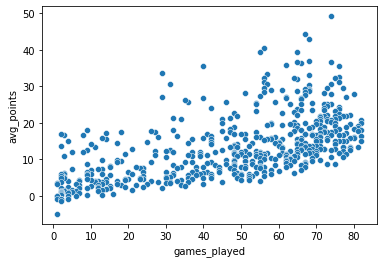

In [5]:
# games_played vs avg_points. want to stratify this vertically 
sns.scatterplot(data=f_scores,x=f_scores['games_played'],y=f_scores['avg_points'])

<AxesSubplot:>

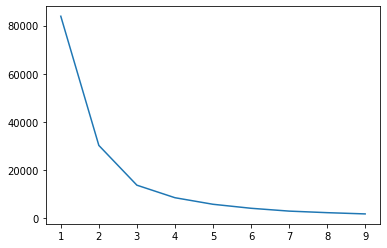

In [7]:
# finding optimium K using within group sum of squares method

wgss = []
# awkward but it works. couldn't get 1d array to work w/ cluster counts. not sure why.
x = f_scores[['avg_points','avg_points']]
for k in range(1,10):
    kmeans = KMeans(k)
    kmeans.fit(x)
    wgss.append(kmeans.inertia_)

# within group sum of sqaures says 3 or 4 clusters
cluster_range = range(1,10)
sns.lineplot(x=cluster_range,y=wgss)

In [8]:
# fitting 3 clusters
k3 = KMeans(3)
k3.fit(x)
f_scores['3cluster'] = k3.fit_predict(x)

# fitting 4 clusters
k4 = KMeans(4)
k4.fit(x)
f_scores['4cluster'] = k4.fit_predict(x)

<AxesSubplot:xlabel='games_played', ylabel='avg_points'>

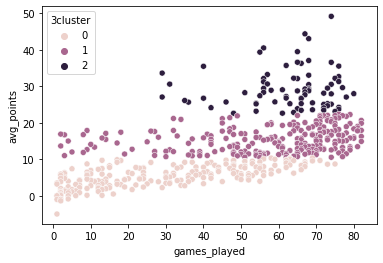

In [9]:
# 3 cluster plot
sns.scatterplot(data=f_scores,x=f_scores['games_played'],y=f_scores['avg_points'], hue=f_scores['3cluster'])

<AxesSubplot:xlabel='games_played', ylabel='avg_points'>

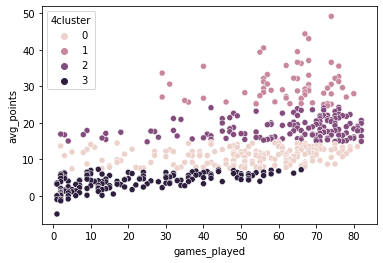

In [10]:
# 4 cluster plot
sns.scatterplot(data=f_scores,x=f_scores['games_played'],y=f_scores['avg_points'], hue=f_scores['4cluster'])

In [11]:
k3_levels = f_scores[['3cluster','avg_points']]
k3_levels = k3_levels.groupby('3cluster').agg({'avg_points':['min','mean','max']}).reset_index()
k3_levels.columns = ['3cluster','min','mean','max']
k3_levels['count'] = k3_levels['3cluster'].map(f_scores['3cluster'].value_counts())

k3_levels.sort_values(by='max', ascending=False).reset_index(drop=True)

,3cluster,min,mean,max,count
0,2,22.625000,29.412334,49.177027,78
1,1,10.483636,15.434905,22.353947,241
2,0,-5.000000,5.370491,10.342029,218


In [12]:
k4_levels = f_scores[['4cluster','avg_points']]
k4_levels = k4_levels.groupby('4cluster').agg({'avg_points':['min','mean','max']}).reset_index()
k4_levels.columns = ['4cluster','min','mean','max']
k4_levels['count'] = k4_levels['4cluster'].map(f_scores['4cluster'].value_counts())

k4_levels.sort_values(by='max', ascending=False).reset_index(drop=True)

,4cluster,min,mean,max,count
0,1,24.661644,30.604055,49.177027,65
1,2,14.784000,18.437143,24.252632,144
2,0,7.400000,10.998217,14.654762,181
3,3,-5.000000,3.740489,7.258333,147
